#####    自回归模型 AR 具备线性模型特征，将时间序列变量当期的realized value作为被解释变数、过去期的历史资料当作解释变数，因此被称作自回归模型。p阶自回归模型的一般表达式为：
    考虑到AR模型的统计性质，在以平稳的时间序列作为对象时，有如下几个特点：
    -AR模型的自相关系数会随着阶数的增加而减小，但是很多阶数之后仍然不归零，因此呈现拖尾现象。
    
    移动平均模型 MA 认为因变量序列xt与随机冲击项的当前值epsilon_t以及q期的滞后值epsilon_t-1等有关，而且是他们的加权平均，其中epsilon是白噪声序列，它的统计均值为零。MA的一般表达式为：
    考虑到MA模型的统计性质，在以平稳的时间序列作为对象时，有如下几个特点：
    -MA模型的自相关系数会随着阶数的增加而减小，但是会在q阶之后马上截止，而非趋近于零。

##### 结合MA(q)与AR(p)两个模型的特征，我们可以将建构ARMA(p,q)自回归移动平均模型。
    

#####    构建ARMA模型大致遵循以下三个步骤：
    1.序列识别：判断需要建模分析的数据是否为平稳序列，若为非平稳序列则需要进行变换处理；进行白噪声序判断，如果为白噪声序列则建模结束。
    2.模型识别与估计：决定p与q值，选出相对最优的模型结构。如果序列的ACF与PACF在统计上不明确，则建立若干个备选模型，根据AIC指标进行筛选。
    3.模型诊断：对模型残差进行检验，确保其服从正态分布的白噪声序列。当模型的残差是白噪声时，说明我们已经将序列的信息充分提取到模型中。

##### 本节我们将建立一个完整的ARMA模型，并用其对序列进行短期的预测，以帮助更好地理解 ARMA 模型。我们使用2014年1月到2015年12月的股票大唐电信日均收益数据建立ARMA模型。

In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.stattools import arma_order_select_ic
from arch.unitroot import ADF
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [322]:
data = pd.read_csv('datang_telecom_2014_2015.csv', index_col='date')
data.index=pd.to_datetime(data.index)
data = data[['pctChg']]
data = data.iloc[::-1]
data

,pctChg
date,
2015-12-31,-6.2334
2015-12-30,6.8643
2015-12-29,6.1665
2015-12-28,-3.7759
2015-12-25,-0.7822
...,...
2014-01-08,2.5836
2014-01-07,1.4649
2014-01-06,-5.1901


<Axes: title={'center': 'DaTang'}, xlabel='date'>

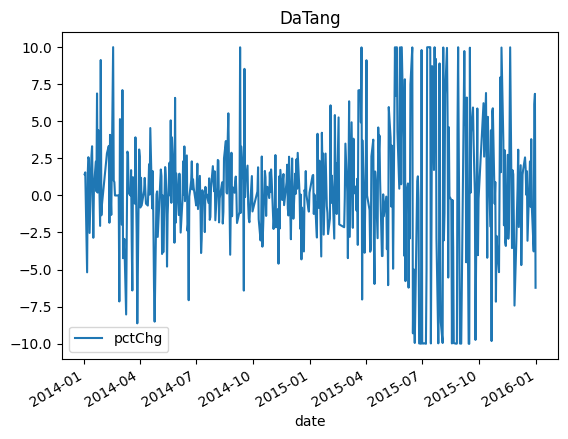

In [309]:
data = data.dropna()
data.plot(title='DaTang')

In [310]:
print(ADF(data, max_lags=20).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -19.477
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


##### 通过ADF进行单位根检验，我们设置最大滞后阶数为10，防止阶数过多导致p值偏低。我们观察到，滞后长度此时为0。这意味着ADF测试发现没有必要在测试回归中包含该系列的任何滞后差异以解释残差的自相关性。测试统计量和p值表明该系列非常平稳，因为测试统计量远低于临界值，并且p值实际上为零。

##### 接下来，我们判断收益序列是否为白噪音序列。我们使用Ljung-Box方法来确定。该检验的原假设是“所检验序列是白噪声序列”

In [311]:
LjungBox=stattools.q_stat(stattools.acf(data)[1:12], len(data))

In [312]:
LjungBox[1][-1]

np.float64(0.015250793005474115)

##### 注意到，此时检验的p值为0.009<0.05（常用显著性水平），因此我们接受责备假设“所检验序列不是白噪声序列”。

##### 我们对测试序列计算其ACF与PACF（如下图），我们发现两图中均有拖尾的性质，因此判断ARMA(p,q)中p与q皆大与零。为了选出最优的模型结构，即有最小的AIC值，我们使用函数arma_order_select_ic（）。

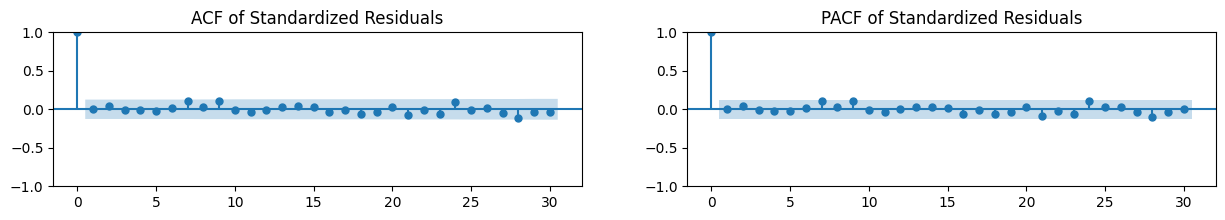

In [313]:
fig, axes = plt.subplots(1, 2, figsize=(15, 2)) 
plot_acf(stdresid, lags=30, ax=axes[0])
axes[0].set_title('ACF of Standardized Residuals')
plot_pacf(stdresid, lags=30, ax=axes[1])
axes[1].set_title('PACF of Standardized Residuals')
plt.show()

In [314]:
stattools.arma_order_select_ic(data, max_ma=4)

{'bic':              0            1            2            3            4
 0  2844.411192  2843.160782  2849.045062  2854.088217  2859.226363
 1  2842.833172  2848.761857  2854.250570  2858.798917  2865.362696
 2  2848.846556  2854.700062  2859.118838  2865.308537  2865.548470
 3  2854.545023  2858.864858  2864.048783  2871.380384  2869.902894
 4  2859.455341  2865.307618  2870.229659  2871.375117  2875.205578,
 'bic_min_order': (np.int64(1), np.int64(0))}

##### 观察可知，当p=1，q=0时，BIC取值最小。所以我们选择ARMA(1,0)模型。

In [315]:
model = sm.tsa.arima.ARIMA(data, order=(1, 0, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 pctChg   No. Observations:                  489
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1412.128
Date:                Wed, 24 Jul 2024   AIC                           2830.256
Time:                        16:25:43   BIC                           2842.833
Sample:                             0   HQIC                          2835.196
                                - 489                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2220      0.225      0.987      0.324      -0.219       0.663
ar.L1          0.1257      0.031      4.032      0.000       0.065       0.187
sigma2        18.8720      1.079     17.494      0.000      16.758      20.986
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.43
Prob(Q):                              0.95   Prob(JB):                         0.07
Heteroskedasticity (H):               0.23   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 接下来，我们进行模型诊断，包括对系数显著性的检验以及对残差序列是否为白噪音的检验。针对系数的显著性，我们利用confint()计算置信区间，得到以下结果。观察可得，在5%的置信水平下，所有系数都是显著的。

In [316]:
model.conf_int()

,0,1
const,-0.218814,0.662847
ar.L1,0.064603,0.186837
sigma2,16.757742,20.986353


##### 接下来，我们计算标准化的残差。如图所示，残差分布于正负3之内，没有显著的偏差值。

In [317]:
residuals = model.resid
stdresid = residuals / np.sqrt(np.var(residuals))

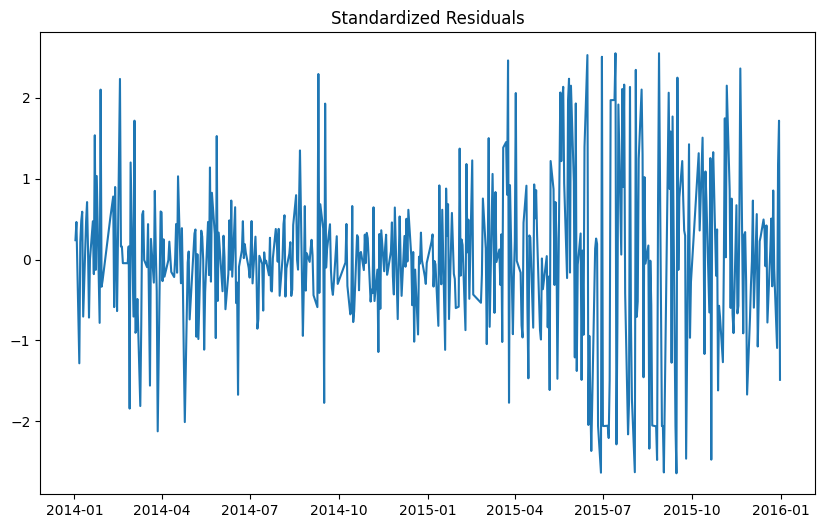

In [318]:
plt.figure(figsize=(10, 6))
plt.plot(stdresid)
plt.title('Standardized Residuals')
plt.show()

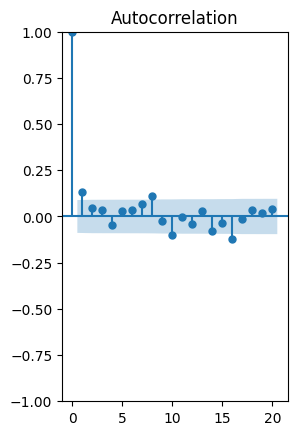

In [319]:
axe1 = plt.subplot(122)
plot1 = plot_acf(datatrain, lags=20, ax=axe1)

In [320]:
Ljungbox = stattools.q_stat(stattools.acf(stdresid)[1:12], len(stdresid))
Ljungbox[1]

array([0.95076479, 0.94180819, 0.81990285, 0.70270217, 0.7670493 ,
       0.81984837, 0.77459185, 0.30758761, 0.37662372, 0.15517884,
       0.20352958])

##### 为了进一步验证残差是不是白噪声序列，我们增加了Ljung-Box检验的滞后阶数。
        -结果如图 24.6 和图24.7所示。从图中可以看出，残差项之间没有显著的自相关性。
        -针对自相关性的LB 检验也有足够高的p值，即残差序列白噪声的原假设不能被拒绝。
##### 基于以上结果，可基本得出结论，我们的模型满足要求。